<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import os
from google.colab import drive

import json
import math
import numpy as np
import pandas as pd
import csv

import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from tensorflow import keras

# Dataset

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=13fPmh97a4_UrmPkktJ-g8_-uEy2KhrCm&confirm=t" -O audios_completos.zip

In [ ]:
!unzip audios.zip

In [ ]:
!unzip audios_completos.zip

In [6]:
os.remove('/content/Audios_disparos_selva/train/fondo/603EFD8C.WAV')
os.remove('/content/Audios_disparos_selva/train/fondo/603EEE5A.WAV')

In [ ]:
drive.mount('/content/drive')

# Explore Dataset

## Auxiliaries functions

In [8]:
FRAME_LENGTH = 1024
HOP_LENGTH = FRAME_LENGTH//2
N_MELS = 40
N_MFCC = 13

In [9]:
def extract_fft(signal):
  signal_fft = sp.fft.fft(signal, FRAME_LENGTH)
  signal_mag = np.abs(signal_fft)

  return signal_fft, signal_mag

In [10]:
def extract_spectrogram(signal):
  return np.abs(librosa.stft(signal,
                             n_fft=FRAME_LENGTH,
                             hop_length=HOP_LENGTH))

In [11]:
def extract_mel_spectrogram(signal, sr):
  signal_mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                          sr=sr,
                                                          n_fft=FRAME_LENGTH,
                                                          hop_length=HOP_LENGTH,
                                                          n_mels=N_MELS)

  signal_log_mel_spectrogram = librosa.power_to_db(signal_mel_spectrogram)

  return signal_log_mel_spectrogram

In [12]:
def extract_mfccs(signal, sr):
  mfccs = librosa.feature.mfcc(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, n_mfcc=N_MFCC, sr=sr)
  return mfccs

In [13]:
def plot_fft(signal, sr, audio_type=None):
  signal_fft, signal_mag = extract_fft(signal)

  frequency = np.linspace(0, sr, len(signal_fft))
  f_bins = FRAME_LENGTH//2 + 1

  plt.figure(figsize=(8, 4))
  plt.plot(frequency[:f_bins], signal_mag[:f_bins])

  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.title(f'Frequency domain spectrum to {audio_type}')
  plt.show()

In [14]:
def plot_spectrogram(signal, y_axis='linear', audio_type=None):
  spectrogram = extract_spectrogram(signal)

  if y_axis == 'log':
    spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(spectrogram,
                           y_axis=y_axis,
                           x_axis='time')

  plt.title(f'Spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()


In [15]:
def plot_mel_spectrogram(signal, sr, audio_type=None):
  mel_spectrogram = extract_mel_spectrogram(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mel_spectrogram,
                           y_axis='mel',
                           x_axis='time')

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()

In [16]:
def plot_mfcc(signal, sr, audio_type=None):
  mfccs = extract_mfccs(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr=sr)

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.ylabel('Coefficients')
  plt.colorbar(format="%+2.f")
  plt.show()

## Load audios names

In [17]:
shoot_dir = '/content/Audios_disparos_selva/train/disparos'
background_dir = '/content/Audios_disparos_selva/train/fondo'

shoot_names = np.array(os.listdir(shoot_dir))
background_names = np.array(os.listdir(background_dir))

In [18]:
len(shoot_names)

597

In [19]:
len(background_names)

10631

## Choose random audio

In [20]:
shoot_path = os.path.join(shoot_dir, np.random.choice(shoot_names))
back_path = os.path.join(background_dir, np.random.choice(background_names))

## Load audios

In [21]:
# shoot
shoot_sound, shoot_sr = librosa.load(shoot_path)

# background
back_sound, back_sr = librosa.load(back_path)

## Basic information regarding audios

In [22]:
shoot_sound.shape

(88200,)

In [23]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / back_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000045 seconds


In [24]:
back_sr

22050

In [25]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

88200

In [26]:
# duration of the audio signal in seconds
duration = duration_sample * len(back_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [27]:
ipd.Audio(shoot_sound, rate=shoot_sr)

In [28]:
ipd.Audio(back_sound, rate=back_sr)

## Visualize graphs

### Frequency domain

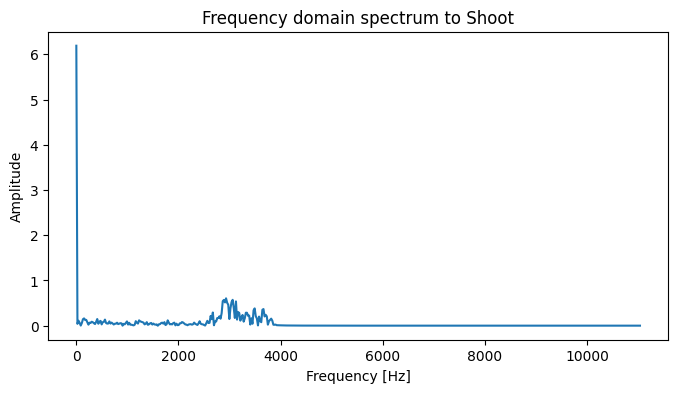

In [29]:
# SHOOT
plot_fft(shoot_sound, shoot_sr, audio_type='Shoot')

In [30]:
shoot_fft, shoot_mag = extract_fft(shoot_sound)

In [31]:
shoot_fft.shape

(1024,)

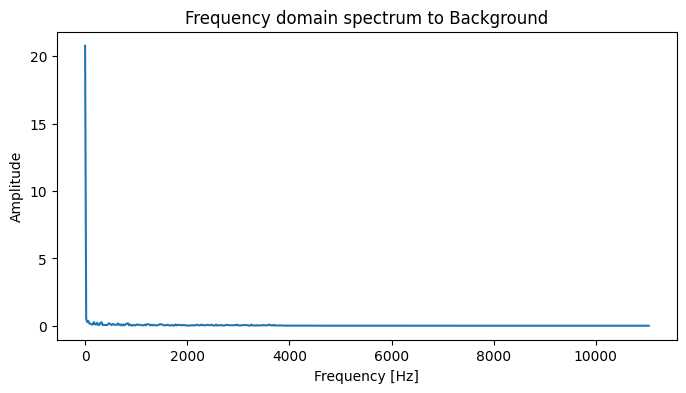

In [32]:
# BACKGROUND
plot_fft(back_sound, back_sr, audio_type='Background')

In [33]:
back_fft, back_mag = extract_fft(back_sound)

In [34]:
back_fft.shape

(1024,)

In [35]:
back_mag.shape

(1024,)

### Spectrogram

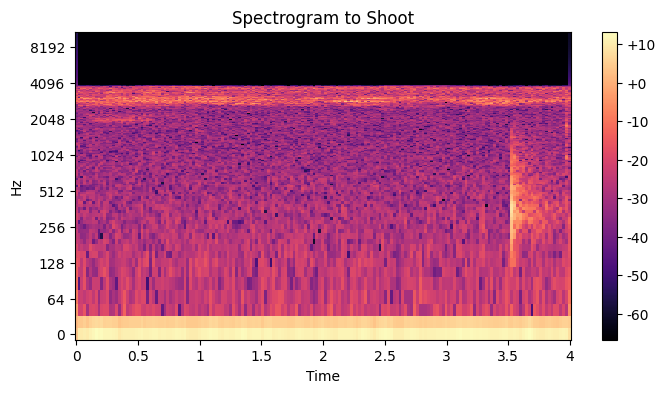

In [36]:
# SHOOT
plot_spectrogram(shoot_sound, y_axis='log', audio_type='Shoot')

In [37]:
shoot_spectrogram = extract_spectrogram(shoot_sound)
shoot_spectrogram.shape

(513, 173)

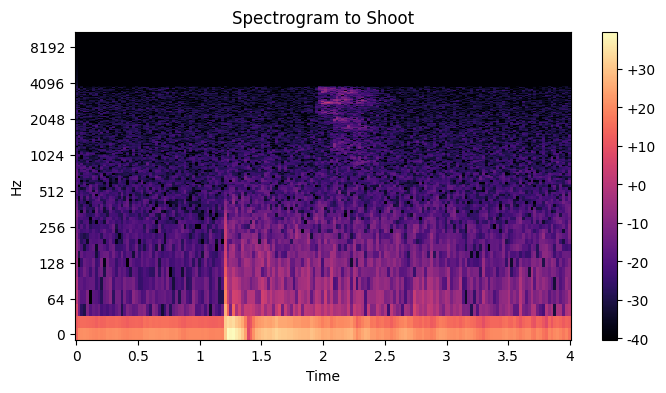

In [38]:
# BACKGROUND
plot_spectrogram(back_sound, y_axis='log', audio_type='Shoot')

In [39]:
back_spectrogram = extract_spectrogram(back_sound)
back_spectrogram.shape

(513, 173)

### Mel spectrogram

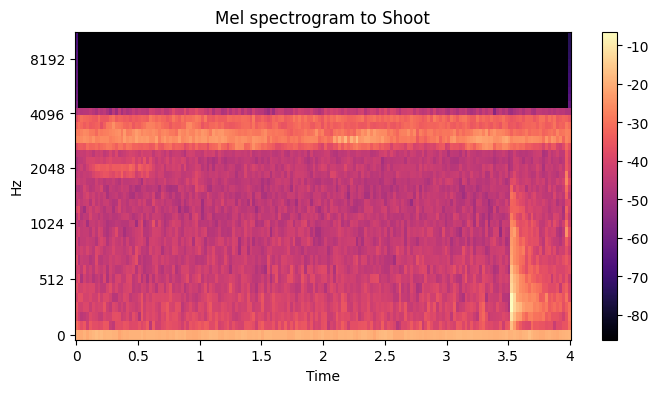

In [40]:
# SHOOT
plot_mel_spectrogram(shoot_sound, shoot_sr, audio_type='Shoot')

In [41]:
shoot_mel_spectrogram = extract_mel_spectrogram(shoot_sound, sr=shoot_sr)
shoot_mel_spectrogram.shape

(40, 173)

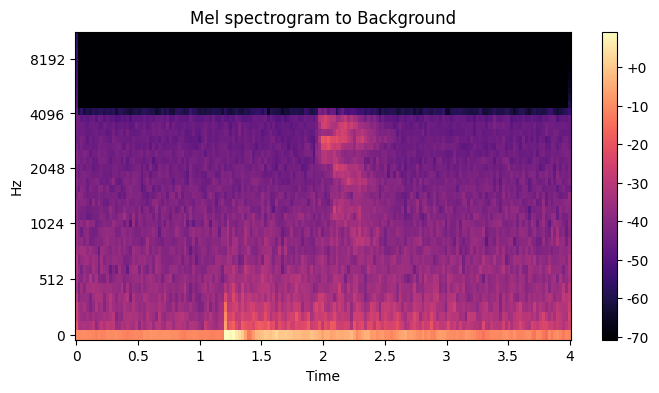

In [42]:
# BACKGROUND
plot_mel_spectrogram(back_sound, back_sr, audio_type='Background')

In [43]:
back_mel_spectrogram = extract_mel_spectrogram(back_sound, back_sr)
back_mel_spectrogram.shape

(40, 173)

### Mel-Frequency Cepstral

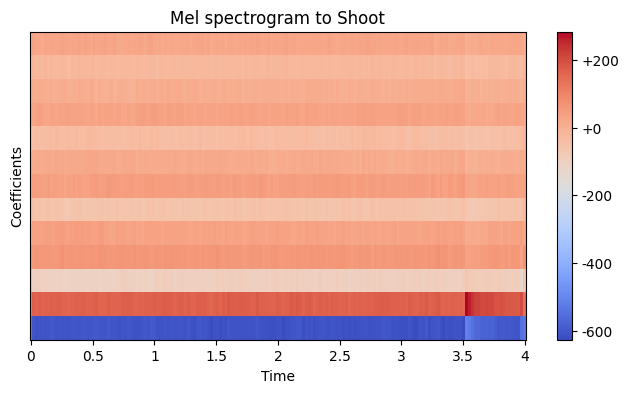

In [44]:
# Shoot
plot_mfcc(shoot_sound, shoot_sr, 'Shoot')

In [45]:
shoot_mfcc = extract_mfccs(shoot_sound, shoot_sr)
shoot_mfcc.shape

(13, 173)

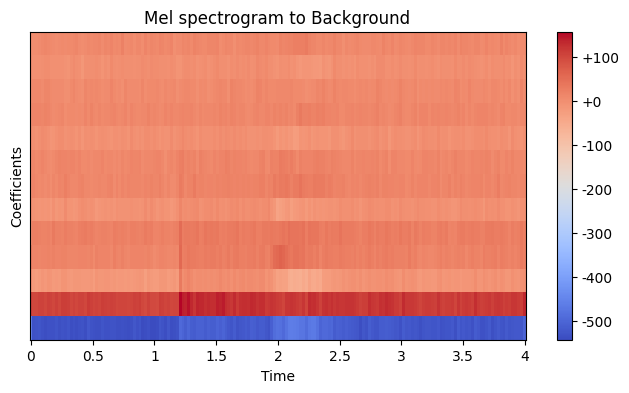

In [46]:
# Background
plot_mfcc(back_sound, back_sr, 'Background')

In [47]:
back_mfcc = extract_mfccs(back_sound, back_sr)
back_mfcc.shape

(13, 173)

# Prepare dataset

In [48]:
DATASET_PATH = '/content/Audios_disparos_selva/val'
TRAIN_JSON_PATH = 'train_data.json'
VAL_JSON_PATH = 'val_data.json'
SAMPLE_RATE = 22050
NUM_SEGMENTS = 5
DURATION = 4 # measured in seconds
SAMPLES_PER_TRACK = DURATION * SAMPLE_RATE

In [87]:
def save_mfcc(dataset_path, json_path, n_mfcc=N_MFCC, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, num_segments=NUM_SEGMENTS):

  # dictionary to store data
  data = {
      'mapping': [],
      'mfcc': [],
      'labels': []
  }

  samples_per_segment = SAMPLES_PER_TRACK // num_segments
  expected_num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  # loop through all the audios types (shoot and background)
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

    # ensure that we're not at the root level
    if dirpath != DATASET_PATH:

      # save the semantic label
      semantic_label = dirpath.split('/')[-1] # shoot or background
      data['mapping'].append(semantic_label)
      print("\nProcessing: {}".format(semantic_label))

      # process file for specific audio type
      for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # process segments extracting mfcc and storing data
        for s in range(num_segments):

          start_sample = samples_per_segment * s
          finish_sample = start_sample + samples_per_segment

          segment = signal[start_sample:finish_sample]

          # Each column represents the MFCCs of each segment
          mfcc = extract_mfccs(segment, sr).T.tolist()

          # store mfcc for segment if it has the expected length
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc)
            data["labels"].append(i-1)
            print("{}, segment: {}".format(file_path, s+1))

  # save MFCCs to json file
  with open(json_path, "w") as fp:
      json.dump(data, fp, indent=2)


In [ ]:
save_mfcc(DATASET_PATH, TRAIN_JSON_PATH)

In [ ]:
save_mfcc(DATASET_PATH, VAL_JSON_PATH)

## Load JSON from drive

In [49]:
train_drive_path = '/content/drive/MyDrive/json_to_tfi/train_data.json'
val_drive_path = '/content/drive/MyDrive/json_to_tfi/val_data.json'

In [50]:
def load_data(dataset_path):
  with open(dataset_path, 'r') as fp:
    data = json.load(fp)

  # convert lists into numpy arrays
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs, targets

In [51]:
def prepare_datasets(test_size):

  """
    Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
  """

  X, y = load_data(train_drive_path)
  X_val, y_val = load_data(val_drive_path)

  # create train and test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

  # add an axis to input sets
  X_train = X_train[..., np.newaxis]
  X_validation = X_val[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_validation, X_test, y_train, y_val, y_test


In [52]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2)

In [53]:
print(f"Train shape: {X_train.shape}")

Train shape: (22192, 35, 13, 1)


In [54]:
print(f"Test shape: {X_test.shape}")

Test shape: (5548, 35, 13, 1)


In [55]:
print(f"Validation shape: {X_validation.shape}")

Validation shape: (27740, 35, 13, 1)


# Implementing a Neural Network

## Plot History

In [56]:
def plot_history(history):
    """
        Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

## Prediction function

In [57]:
def predict(model, X, y):
  """Predict a single sample using the trained model

  :param model: Trained classifier
  :param X: Input data
  :param y (int): Target
  """

  # add a dimension to input data for sample - model.predict() expects a 4d array in this case
  X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

  # perform prediction
  prediction = model.predict(X)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Target: {}, Predicted label: {}".format(y, predicted_index))

## Only dense

In [67]:
model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),

        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),

        # 3rd hidden layer
        keras.layers.Dense(64, activation="relu"),

        # output layer
        keras.layers.Dense(2, activation="softmax")
        ])

## Convolutional Network

In [58]:
def build_model(input_shape):

  """Generates CNN model

  :param input_shape (tuple): Shape of input set
  :return model: CNN model
  """

  # create model
  model = keras.Sequential()

  # 1st conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # 2nd conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # 3rd conv layer
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # flatten output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model


In [59]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

## Compile network

In [60]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 17, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 2, 32)          0         
 g2D)                                                            
                                                        

In [62]:
# train model
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30, callbacks=[callback])

Epoch 1/30
694/694 [==============================] - 12s 7ms/step - loss: 0.3643 - accuracy: 0.8523 - val_loss: 0.1195 - val_accuracy: 0.9726
Epoch 2/30
694/694 [==============================] - 4s 6ms/step - loss: 0.1189 - accuracy: 0.9712 - val_loss: 0.0991 - val_accuracy: 0.9757
Epoch 3/30
694/694 [==============================] - 5s 7ms/step - loss: 0.1010 - accuracy: 0.9744 - val_loss: 0.0969 - val_accuracy: 0.9766
Epoch 4/30
694/694 [==============================] - 4s 6ms/step - loss: 0.0911 - accuracy: 0.9767 - val_loss: 0.0854 - val_accuracy: 0.9780
Epoch 5/30
694/694 [==============================] - 4s 6ms/step - loss: 0.0846 - accuracy: 0.9774 - val_loss: 0.0875 - val_accuracy: 0.9769
Epoch 6/30
694/694 [==============================] - 5s 7ms/step - loss: 0.0815 - accuracy: 0.9788 - val_loss: 0.0800 - val_accuracy: 0.9776
Epoch 7/30
694/694 [==============================] - 5s 7ms/step - loss: 0.0756 - accuracy: 0.9795 - val_loss: 0.0792 - val_accuracy: 0.9773
Epoch

## Evaluate model on val set

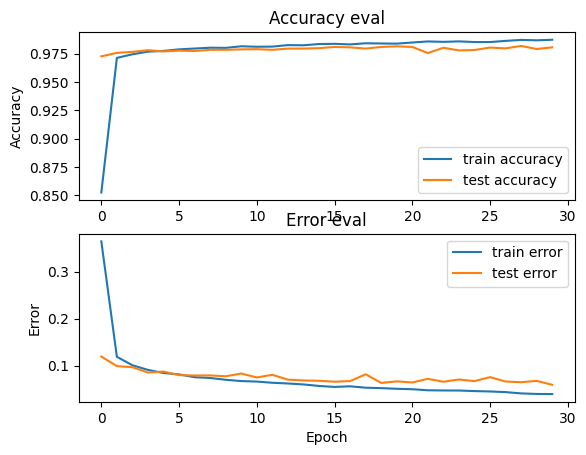

In [63]:
plot_history(history)

In [64]:
# evaluate model on val set
val_loss, val_acc = model.evaluate(X_validation, y_validation, verbose=2)
print('\nVal accuracy:', val_acc)

867/867 - 2s - loss: 0.0367 - accuracy: 0.9885 - 2s/epoch - 2ms/step

Val accuracy: 0.9885364174842834


In [65]:
shoot_index = [i for i, e in enumerate(y_test) if e == 1]
X_shoot = X_test[shoot_index[:]]
y_shoot = y_test[shoot_index[:]]

In [66]:
# evaluate model on val set only shoots
val_loss, val_acc = model.evaluate(X_shoot, y_shoot, verbose=2)
print('\nTest accuracy:', val_acc)

169/169 - 0s - loss: 0.0192 - accuracy: 0.9956 - 478ms/epoch - 3ms/step

Test accuracy: 0.9955547451972961


In [76]:
# pick a sample to predict from the test set
X_to_predict = X_validation[300]
y_to_predict = y_validation[300]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 30ms/step
Target: 0, Predicted label: [0]


## Save model

In [77]:
model.save("CNN_MODEL.keras")

## Load model

In [110]:
CNN_model = keras.models.load_model("CNN_MODEL.keras")